In [1]:
# -*- coding: utf-8 -*-

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from imageio import imread, imsave, mimsave
import cv2
import glob
from tqdm import tqdm

In [2]:
dataset = 'RS_Cut_Result' # LFW
# dataset = 'celeba' # CelebA
images = glob.glob(os.path.join(dataset, '*.*')) 
print(len(images))

19200


In [3]:
batch_size = 100
z_dim = 100
WIDTH = 64
HEIGHT = 64
LAMBDA = 10
DIS_ITERS = 3 # 5

OUTPUT_DIR = 'samples_' + dataset
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

X = tf.placeholder(dtype=tf.float32, shape=[batch_size, HEIGHT, WIDTH, 3], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[batch_size, z_dim], name='noise')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

def lrelu(x, leak=0.2):
    return tf.maximum(x, leak * x)

In [4]:
def discriminator(image, reuse=None, is_training=is_training):
    momentum = 0.9
    with tf.variable_scope('discriminator', reuse=reuse):
        h0 = lrelu(tf.layers.conv2d(image, kernel_size=5, filters=64, strides=2, padding='same'))
        
        h1 = lrelu(tf.layers.conv2d(h0, kernel_size=5, filters=128, strides=2, padding='same'))
        
        h2 = lrelu(tf.layers.conv2d(h1, kernel_size=5, filters=256, strides=2, padding='same'))
        
        h3 = lrelu(tf.layers.conv2d(h2, kernel_size=5, filters=512, strides=2, padding='same'))
        
        h4 = tf.contrib.layers.flatten(h3)
        h4 = tf.layers.dense(h4, units=1)
        return h4

In [5]:
def generator(z, is_training=is_training):
    momentum = 0.9
    with tf.variable_scope('generator', reuse=None):
        d = 4
        h0 = tf.layers.dense(z, units=d * d * 512)
        h0 = tf.reshape(h0, shape=[-1, d, d, 512])
        h0 = tf.nn.relu(tf.contrib.layers.batch_norm(h0, is_training=is_training, decay=momentum))
        
        h1 = tf.layers.conv2d_transpose(h0, kernel_size=5, filters=256, strides=2, padding='same')
        h1 = tf.nn.relu(tf.contrib.layers.batch_norm(h1, is_training=is_training, decay=momentum))
        
        h2 = tf.layers.conv2d_transpose(h1, kernel_size=5, filters=128, strides=2, padding='same')
        h2 = tf.nn.relu(tf.contrib.layers.batch_norm(h2, is_training=is_training, decay=momentum))
        
        h3 = tf.layers.conv2d_transpose(h2, kernel_size=5, filters=64, strides=2, padding='same')
        h3 = tf.nn.relu(tf.contrib.layers.batch_norm(h3, is_training=is_training, decay=momentum))
        
        h4 = tf.layers.conv2d_transpose(h3, kernel_size=5, filters=3, strides=2, padding='same', activation=tf.nn.tanh, name='g')
        return h4

In [6]:
g = generator(noise)
d_real = discriminator(X)
d_fake = discriminator(g, reuse=True)

loss_d_real = -tf.reduce_mean(d_real)
loss_d_fake = tf.reduce_mean(d_fake)
loss_g = -tf.reduce_mean(d_fake)
loss_d = loss_d_real + loss_d_fake

alpha = tf.random_uniform(shape=[batch_size, 1, 1, 1], minval=0., maxval=1.)
interpolates = alpha * X + (1 - alpha) * g
grad = tf.gradients(discriminator(interpolates, reuse=True), [interpolates])[0]
slop = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1]))
gp = tf.reduce_mean((slop - 1.) ** 2)
loss_d += LAMBDA * gp

vars_g = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.flatten instead.


In [7]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_d, var_list=vars_d)
    optimizer_g = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_g, var_list=vars_g)

Instructions for updating:
Use tf.cast instead.


In [8]:
def read_image(path, height, width):
    image = imread(path)
    h = image.shape[0]
    w = image.shape[1]
    
    if h > w:
        image = image[h // 2 - w // 2: h // 2 + w // 2, :, :]
    else:
        image = image[:, w // 2 - h // 2: w // 2 + h // 2, :]    
    
    image = cv2.resize(image, (width, height))
    return image / 255.

In [9]:
def montage(images):    
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    if len(images.shape) == 4 and images.shape[3] == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5
    elif len(images.shape) == 4 and images.shape[3] == 1:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 1)) * 0.5
    elif len(images.shape) == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1)) * 0.5
    else:
        raise ValueError('Could not parse image shape of {}'.format(images.shape))
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

In [10]:
def get_random_batch(nums):
    img_index = np.arange(len(images))
    np.random.shuffle(img_index)
    img_index = img_index[:nums]
    batch = np.array([read_image(images[i], HEIGHT, WIDTH) for i in img_index])
    batch = (batch - 0.5) * 2
    
    return batch

  0%|                                                                                        | 0/30000 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0 8.039551 1.3404068


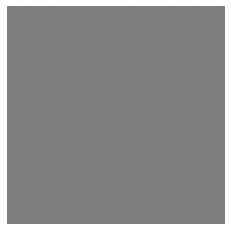

  7%|█████                                                                      | 2000/30000 [35:43<8:07:39,  1.04s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


2000 -838.052 5056.635


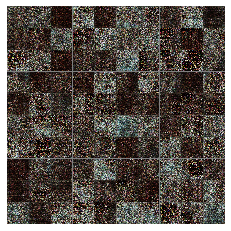

 13%|█████████▋                                                               | 4000/30000 [1:09:46<7:21:10,  1.02s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


4000 -327.9065 2458.9736


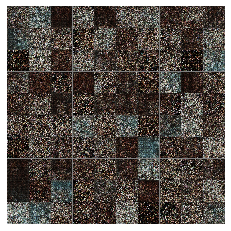

 20%|██████████████▌                                                          | 6000/30000 [1:43:46<6:52:53,  1.03s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


6000 -203.37885 1445.001


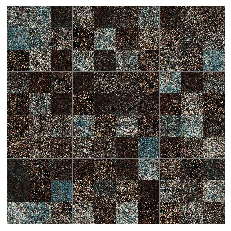

 27%|███████████████████▍                                                     | 8000/30000 [2:17:59<6:13:36,  1.02s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


8000 -27.957726 1817.1753


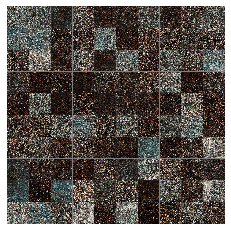

 33%|████████████████████████                                                | 10000/30000 [2:52:01<5:40:02,  1.02s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


10000 -109.44011 164.30527


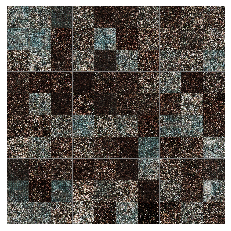

 40%|████████████████████████████▊                                           | 12000/30000 [3:26:04<5:05:26,  1.02s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


12000 -109.63433 -348.09976


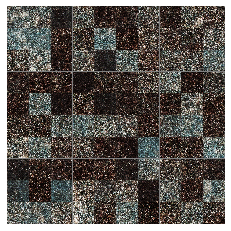

 47%|█████████████████████████████████▌                                      | 14000/30000 [4:00:07<4:32:27,  1.02s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


14000 -79.983864 -307.85022


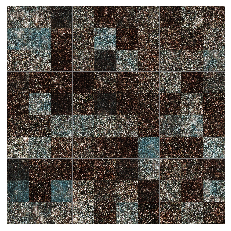

 53%|██████████████████████████████████████▍                                 | 16000/30000 [4:34:13<3:58:46,  1.02s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


16000 -46.774483 254.52022


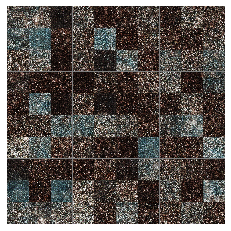

 60%|███████████████████████████████████████████▏                            | 18000/30000 [5:08:18<3:22:15,  1.01s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


18000 -42.436687 -958.35


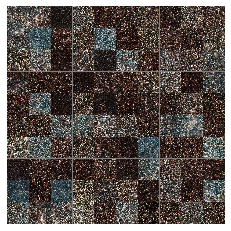

 67%|████████████████████████████████████████████████                        | 20000/30000 [5:42:23<2:49:57,  1.02s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


20000 -17.80983 -149.2695


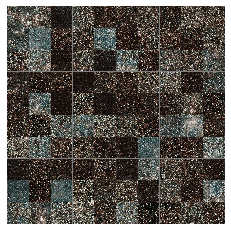

 73%|████████████████████████████████████████████████████▊                   | 22000/30000 [6:16:30<2:17:09,  1.03s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


22000 -0.7242317 455.94797


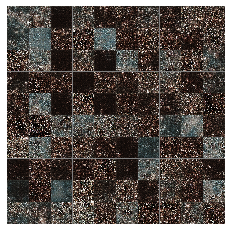

 80%|█████████████████████████████████████████████████████████▌              | 24000/30000 [6:50:32<1:41:22,  1.01s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


24000 -8.508295 648.696


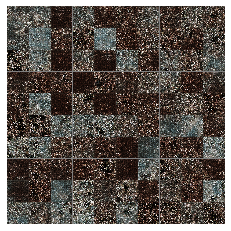

 87%|██████████████████████████████████████████████████████████████▍         | 26000/30000 [7:24:35<1:07:52,  1.02s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


26000 -34.473713 977.0108


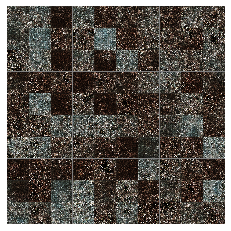

 93%|█████████████████████████████████████████████████████████████████████     | 28000/30000 [7:58:41<34:07,  1.02s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


28000 -38.229355 253.84615


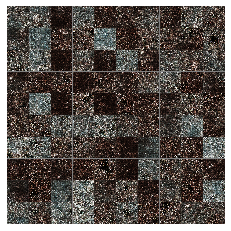

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [8:32:45<00:00,  1.03s/it]


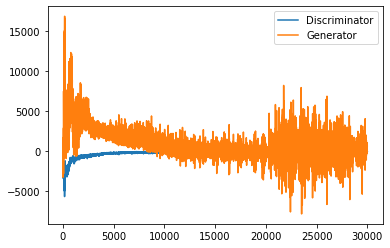

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
z_samples = np.random.uniform(-1.0, 1.0, [batch_size, z_dim]).astype(np.float32)
samples = []
loss = {'d': [], 'g': []}

for i in tqdm(range(30000)):
    for j in range(DIS_ITERS):
        n = np.random.uniform(-1.0, 1.0, [batch_size, z_dim]).astype(np.float32)
        batch = get_random_batch(batch_size)
        _, d_ls = sess.run([optimizer_d, loss_d], feed_dict={X: batch, noise: n, is_training: True})
    
    _, g_ls = sess.run([optimizer_g, loss_g], feed_dict={X: batch, noise: n, is_training: True})
    
    loss['d'].append(d_ls)
    loss['g'].append(g_ls)
    
    if i % 2000 == 0:
        print(i, d_ls, g_ls)
        gen_imgs = sess.run(g, feed_dict={noise: z_samples, is_training: False})
        gen_imgs = (gen_imgs + 1) / 2
        imgs = [img[:, :, :] for img in gen_imgs]
        gen_imgs = montage(imgs)
        plt.axis('off')
        plt.imshow(gen_imgs)
        imsave(os.path.join(OUTPUT_DIR, 'sample_%d.jpg' % i), gen_imgs)
        plt.show()
        samples.append(gen_imgs)

plt.plot(loss['d'], label='Discriminator')
plt.plot(loss['g'], label='Generator')
plt.legend(loc='upper right')
plt.savefig(os.path.join(OUTPUT_DIR, 'Loss.png'))
plt.show()
mimsave(os.path.join(OUTPUT_DIR, 'samples.gif'), samples, fps=10)

In [12]:
saver = tf.train.Saver()
saver.save(sess, os.path.join(OUTPUT_DIR, 'wgan_' + dataset), global_step=60000)

'samples_RS_Cut_Result\\wgan_RS_Cut_Result-60000'